## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [2]:
!pip install --upgrade pip
!pip install --upgrade datasets fsspec huggingface_hub

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [3]:
!pip install nlp
#nlp is old version of datasets so we'll use datasets
!pip install datasets
!pip install tensorflow

In [135]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

# we'll pass the history object that we get after model training in tensorflow to this function
# then this function is going to plot the accuracy, the validation accuracy, the loss and the validation laws for that training
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    #accuracy
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')

    #validation accuracy
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')

    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    #loss
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')

    #validation loss
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# use confusion matrix from sklearn and calculate our predictions against the ground truth
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [138]:
# we'll use hugging face nlp module, datasets is new version of nlp
from datasets import load_dataset

dataset = load_dataset('emotion')

In [139]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [140]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

# Label decoder (as labels are in in but we need them in string)
label_names = dataset['train'].features['label'].int2str

In [141]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [label_names(x['label']) for x in data]  # decode integer label to string
  return tweets, labels

In [142]:
tweets,labels = get_tweet(train)

In [143]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets (break sentences into words and convert those words into numbers)

In [145]:
from tensorflow.keras.preprocessing.text import Tokenizer

<li> create tokenizer object from Tokenizer class which we just imported. </li>
<li> we will use <b>10000(num_words)</b> most frequently used words from our corpus.</li>
<li>we will set an  out of vocabulary token <b>(oov_token)</b> to a string which is unlikely to be present in our corpus <b>('UNK')</b></li>

So, we are going to use most frequently used 10000 words from our corpus and anything taht is not present in those most frequently used 10000 words is tokenized/represented as the token 'UNK'

In [147]:
# create corpus of all the words in a dataset and give each unique word a unique corresponding token
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')

#create mapping from the words to numeric tokens
tokenizer.fit_on_texts(tweets)

In [148]:
#Example of what the tokenizer is doing
print(tweets[0])
tokenizer.texts_to_sequences([tweets[0]])

i didnt feel humiliated


[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

we need to pad or even truncate the sequences as the lengths of tweets are not same

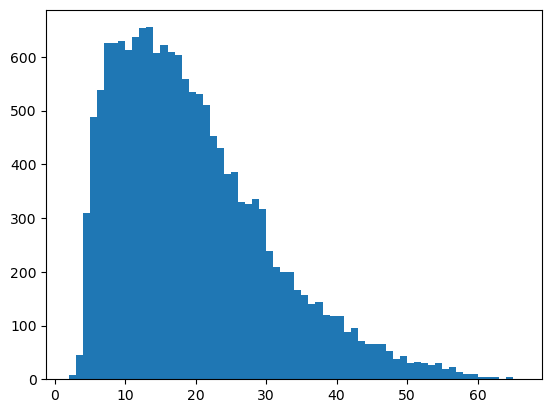

In [150]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths))) #no. of bins set to number of unique lengths we have in our dataset
plt.show()

<li> Any tweet which is more than 50 words long, we will chop them off and we'll simply truncate them </li>
<li> Any tweets which is less than 50 words long, we'll pad those sequences with just zeros</li>

In [152]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

Now, we'll define a function called get sequences which we will use to get sequences for our different sets

<li><b>truncating = 'post'</b> and <b>padding = 'post'</b> means truncating and padding will happen at the end of the sequence. </li>

In [154]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

In [155]:
padded_train_seq = get_sequences(tokenizer,tweets)

In [156]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [158]:
classes = set(labels) #creates a set of unique labels from our training set
print(classes)

{'fear', 'sadness', 'joy', 'anger', 'love', 'surprise'}


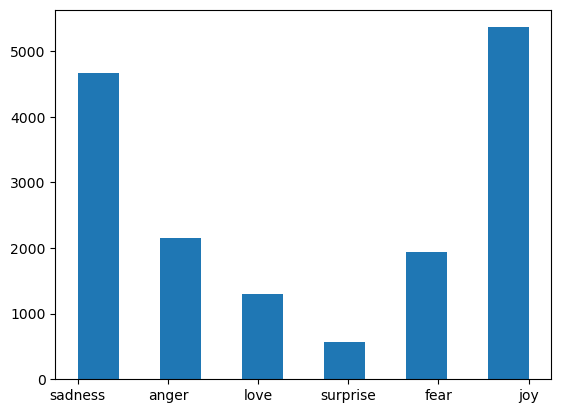

In [159]:
# visualize number of examples we have to different classes
plt.hist(labels, bins=11)
plt.show()

clearly there is a class imbalance. we ignore that for now.


We'll now create dictionaries to convert the names of the classes to corresponding numeric values and vice-versa

In [162]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [163]:
class_to_index

{'fear': 0, 'sadness': 1, 'joy': 2, 'anger': 3, 'love': 4, 'surprise': 5}

In [164]:
index_to_class

{0: 'fear', 1: 'sadness', 2: 'joy', 3: 'anger', 4: 'love', 5: 'surprise'}

We'll create a function to convert names to ids or numberic values and labels will return a numpy array which will have the numeric values

In [166]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])


In [167]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [169]:
# we'll use sequencial class from keras
# we pass a list of layers in the bracket after sequential to create our model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

**10000** input dimension and **16** output dimension

*   since we're using lstm layer inside bidirectional layer, the context in LSTM can go both left to right and right to left
* in dense layer, **6** for the  6 classes that we have



In [171]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [173]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [174]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

# h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

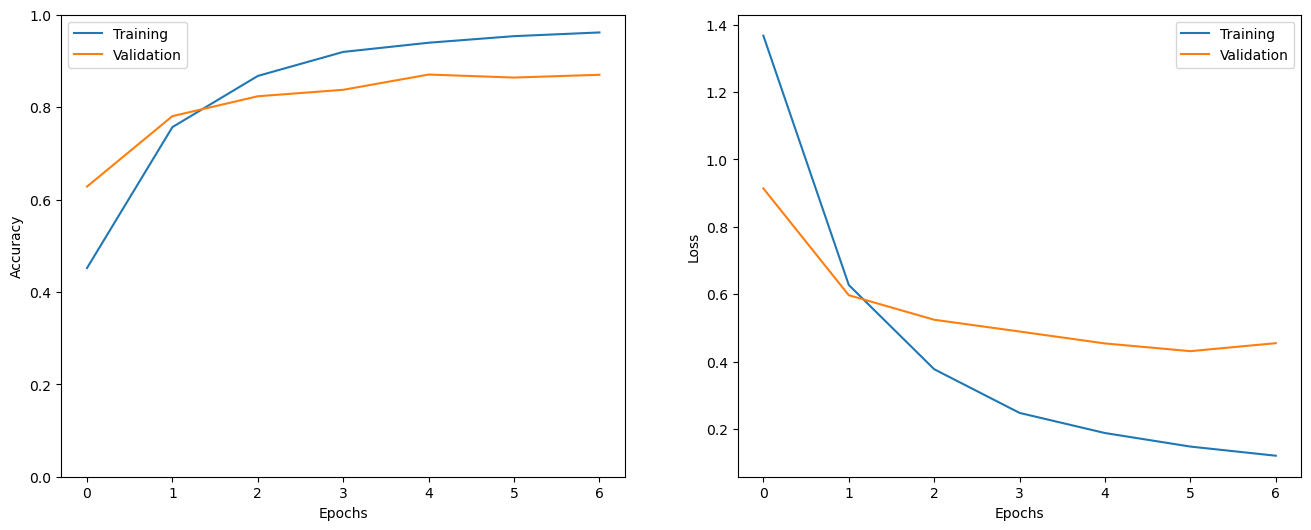

In [128]:
show_history(h)

In [133]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [134]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8667 - loss: 0.4498


In [135]:
i = random.randint(0, len(test_labels)-1)

print("Sentence:", test_tweets[i])
print("Emotion:", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i have this grave feeling it will not be back until tomorrow and strangely enough i have accepted it
Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion: love


In [136]:
#preds = model.predict_classes(test_seq)
preds = np.argmax(model.predict(test_seq), axis=-1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


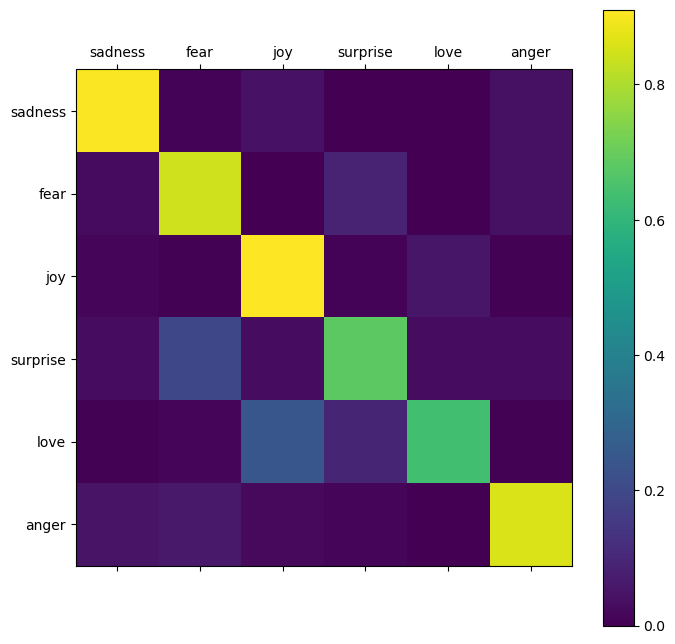

In [145]:
show_confusion_matrix(test_labels, preds, list(classes))